In [90]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from PIL.ExifTags import TAGS
import imagehash

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
tf.__version__

'2.16.2'

# Background on the dataset

The dataset was downloaded from [kaggle](https://www.kaggle.com/datasets/msambare/fer2013/data) and derived from a [2013 Facial Recognition Kaggle competition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data).

"The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples."

## Download the dataset

I downloaded the dataset from kaggle manually: https://www.kaggle.com/datasets/msambare/fer2013/data 

I then saved it in a `data` folder in the root of this project so that it can be accessed with the relative path, `../data/FER-2013`.

## Explore the Image metadata

We will use the training set for exploratory analysis. It consists of 28,709 examples of facial expressions.

The data I downloaded didn't come with a metadata overview so I have written a function to extract some key bits of information and verify the following assumptions:

- all the images are 48x48 pixels
- all the images are grayscale
- the images do not contain EXIF data

### EXIF data

EXIF stands for Exchangeable Image File Format. It is the standard way to store technical information about digital images e.g. the camera settings (shutter speed, ISO, aperture, and focal length), time and date, orientation and location (GPS) information.

This information can be useful for inferring the quality of the image e.g. 
- shutter speed is the length of time a camera shutter is open. A slow shutter speed means more light enters the camera sensor. A very low shutter speed can lead to blur, especially for a moving image. In our scenario a very low shutter speed may indicate blurry picture.
- ISO is a setting that controls how sensitive the camera is to light. Higher ISOs are associated with more grainy or noisy images
- Aperture is the size of the hole in the lens and is another mechanism of controlling how much light passes to the camera sensor

In [96]:
# https://pillow.readthedocs.io/en/stable/handbook/concepts.html
modes = {
    '1' :'1-bit pixels, black and white, stored with one pixel per byte',
    'L': '8-bit pixels, grayscale',
    'P' :'8-bit pixels, mapped to any other mode using a color palette',
    'RGB': '3x8-bit pixels, true color',
    'RGBA': '4x8-bit pixels, true color with transparency mask',
    'CMYK': '4x8-bit pixels, color separation',
    'YCbCr': '3x8-bit pixels, color video format',
    'LAB':'3x8-bit pixels, the L*a*b color space',
    'HSV': '3x8-bit pixels, Hue, Saturation, Value color space',
    'I' :'32-bit signed integer pixels',
    'F' :'32-bit floating point pixels'
}

def get_noise_score(img, width, height):
    """
    Calculate the standard deviation of pixel values.
    
    This function divides the image into smaller windows and calculate the standard deviation
    of the pixel values. With the idea that noisy regions are those with higher 
    standard deviation compared to clean areas.
    """
    noise_score = 0
    window_size = 16

    img_array = np.array(img)
    
    for y in range(0, height - window_size, window_size):
        for x in range(0, width - window_size, window_size):
            window = img_array[y:y+window_size, x:x+window_size]
            window_std = np.std(window)
            noise_score += window_std

    return noise_score / (height * width)
    
    
def get_meta(data_path):
    file_meta = []
    

    for name in os.listdir(data_path): 
        filepath = os.path.join(data_path, name)

        if '.DS_Store' in filepath:
            continue

        for image_file_name in os.listdir(filepath): 
            image_filepath = os.path.join(filepath, image_file_name)
        
            stats = os.stat(image_filepath)
            with Image.open(image_filepath) as img:
                width, height = img.size
    
                mode = img.mode

                exif_data = img.getexif()

                exif_details = []

                if exif_data:
                    for tag, value in exif_data.items():
                        tag_name = TAGS.get(tag, tag)
                        exif_details.append(f"{tag_name}:{value}")
                
                attrs = {
                    'category': name,
                    'file_name': image_file_name,
                    'file_path': image_filepath,
                    'size_kb': round(stats.st_size/1024,2),
                    'dimensions': f"{width}x{height}",
                    'mode': mode,
                    'mode_desc': modes.get(mode, 'unknown'),
                    'image_format': img.format,
                    'is_jpg_extension': '.jpg' in image_file_name,
                    'exif_details': exif_details,
                    'noise_score': get_noise_score(img, width, height),
                    'hash_value': str(imagehash.phash(img))
                }
                file_meta.append(attrs)
    

    
    return file_meta 

In [97]:
test_data_folder = "../data/FER-2013/train/"

meta = get_meta(test_data_folder)

df_meta = pd.DataFrame(meta)
df_meta.head()

,category,file_name,file_path,size_kb,dimensions,mode,mode_desc,image_format,is_jpg_extension,exif_details,noise_score,hash_value
0,happy,Training_50449107.jpg,../data/FER-2013/train/happy/Training_50449107...,1.45,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.072168,84f817c1b63f186b
1,happy,Training_70433018.jpg,../data/FER-2013/train/happy/Training_70433018...,1.35,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.044953,eac1ebc2b13c65e0
2,happy,Training_85610005.jpg,../data/FER-2013/train/happy/Training_85610005...,1.43,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.055432,80e85fe7702659ae
3,happy,Training_4460748.jpg,../data/FER-2013/train/happy/Training_4460748.jpg,1.41,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.049047,880905f785de45bf
4,happy,Training_6312930.jpg,../data/FER-2013/train/happy/Training_6312930.jpg,1.66,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.075139,e8902b2bd2d3d4cb


In [39]:
df_meta.describe()

,size_kb
count,28709.000000
mean,1.537030
std,0.158096
min,0.350000
25%,1.440000
50%,1.540000
75%,1.640000
max,2.340000


### Randomly sampling images

A random sample of the data reveals that:

- not all the data are photographs of real people: we have at least one cartoon!
- the lighting is inconsistent
- some of the images are blurry
- some of the images have marks on them

In [53]:
def load_print_images(file_paths):
    for image_path in file_paths:
        img = load_img(image_path)
        display(img)
    

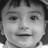

In [55]:
df_meta_sample = df_meta.sample(n=50, replace=False, random_state=42)
df_sample_file_paths = df_meta_sample["file_path"]
categories = list(df_meta_sample["category"])

sample_images = [load_img(image_path) for image_path in df_sample_file_paths]
sample_images[0]

happy 0


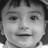

sad 1


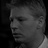

angry 2


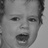

happy 3


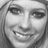

angry 4


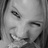

happy 5


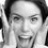

happy 6


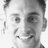

angry 7


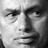

happy 8


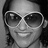

surprise 9


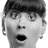

fear 10


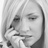

neutral 11


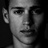

surprise 12


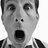

sad 13


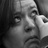

happy 14


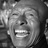

neutral 15


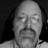

neutral 16


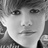

disgust 17


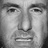

happy 18


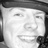

angry 19


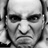

fear 20


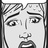

neutral 21


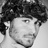

fear 22


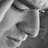

neutral 23


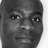

sad 24


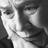

happy 25


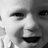

neutral 26


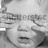

sad 27


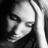

happy 28


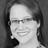

happy 29


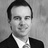

neutral 30


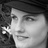

sad 31


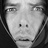

happy 32


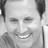

sad 33


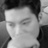

angry 34


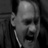

angry 35


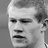

fear 36


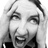

sad 37


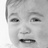

sad 38


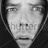

happy 39


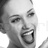

happy 40


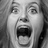

sad 41


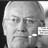

angry 42


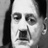

sad 43


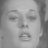

sad 44


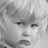

sad 45


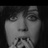

surprise 46


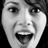

angry 47


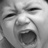

happy 48


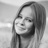

angry 49


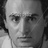

In [7]:
for i, img in enumerate(sample_images):
    print(categories[i], i)
    display(img)

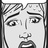

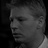

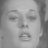

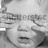

In [8]:
cartoon_image = sample_images[20]
dark_image = sample_images[1]
blurry_image = sample_images[43]
watermark_image = sample_images[26]
display(cartoon_image, dark_image,  blurry_image, watermark_image)

### Image resolution

All of our training data is 48 x 48 pixels. This is fairly small but since our classification task is quite simple, it is ok.

In [9]:
df_meta["dimensions"].value_counts()

dimensions
48x48    28709
Name: count, dtype: int64

### File format

All the image files are JPEGs.

In [54]:
df_meta["image_format"].value_counts()

image_format
JPEG    28709
Name: count, dtype: int64

### Data Type

All of our data is grayscale.

In [10]:
df_meta["mode_desc"].value_counts()

mode_desc
8-bit pixels, grayscale    28709
Name: count, dtype: int64

### Image file size

All our files are under 2.35 KB. They are all small compressed images which can mean that the quality might be degraded: we have already seen from our random selection that there is some blurring. On a plus point, smaller sizes usually mean faster training time.

If the image quality is degraded there are some techniques we could use:
- data augmentation: by modifying the existing images (rotating, scaling, brightness adjustments) you can make the model become more robust to noise
- noise reduction: the compression process may have introduced noise into the image, we can use algorithms to remove or reduce noise

In [34]:
df_meta["size_kb"].describe()

count    28709.000000
mean         1.537030
std          0.158096
min          0.350000
25%          1.440000
50%          1.540000
75%          1.640000
max          2.340000
Name: size_kb, dtype: float64

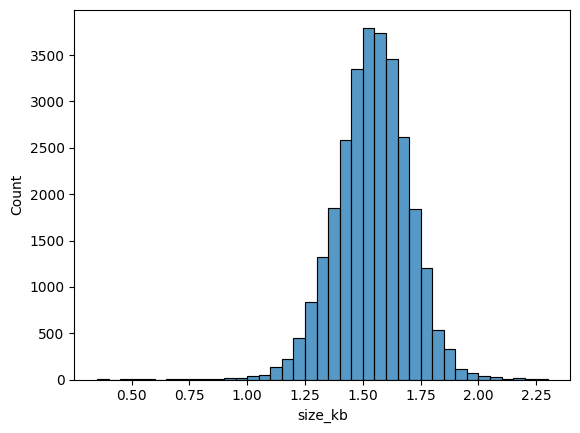

In [35]:
bin_edges = np.arange(0.35, 2.35, 0.05)
sns.histplot(data = df_meta, x="size_kb", bins=bin_edges)
plt.show()

### Class distribution

Our training images have been categorised into 7 different emotions: 
- angry
- disgust
- fear
- happy
- neutral
- sad
- surprise

We can see that the distribution across classes is very imbalanced with over 25% of the images categorised as "happy". 

Having an imbalanced dataset can lead to models that do not generalise well to other datasets. There are a couple of strategies for overcoming this imbalance that we can look at when training our model e.g. 

- **data augmentation**: we can create new images of underrepresented categories (e.g. "disgust") by making small adjustments to images in that class and adding them to our dataset. You don't need to create a perfect 1:1 ratio with the majority class, just bring the number closer.
- **class weights**: we can tell the algorithm to penalise the misclassification of the underrepresented categories more. Misclassifying these categories will have a larger impact on the overall loss. All of the categories contribute to the loss but by applying different weights - higher for underrepresented, lower for overrepresented, we can balance out their representation. Some experimentation is needed to find the best weight. A good starting off point is to make the weights inversely proportional to the number of samples in each class

In [11]:
df_meta["category"].value_counts(normalize=True)

category
happy       0.251315
neutral     0.172942
sad         0.168240
fear        0.142708
angry       0.139155
surprise    0.110453
disgust     0.015187
Name: proportion, dtype: float64

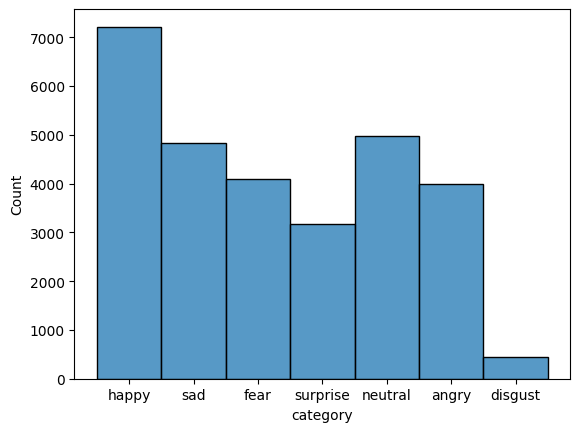

In [12]:
sns.histplot(data=df_meta, x="category")
plt.show()

## Image quality

### Noise
Noise is random variations in image data that can reduce the quality of the image. This can happen when an image is compressed. During compression, the image size is reduced by discarding some of the data. This can introduce blockiness or blurring.

**Why is this a problem for Machine Learning?**

Just like blur stops a human from being able to see an image clearly, for a machine, noise can obscure important features in an image, making it harder to distinguish between the true signal and background clutter.

#### EXIF Data

Can we infer anything about the quality of the images from EXIF data?

Unfortunately our data has no EXIF information we can use.

In [10]:
df_meta["exif_details"].value_counts()

exif_details
[]    28709
Name: count, dtype: int64

### Noise score

We used a simple algorithm that looped through sections of each image, calculated the standard deviation for each section and summed the results to give a measure of noise.



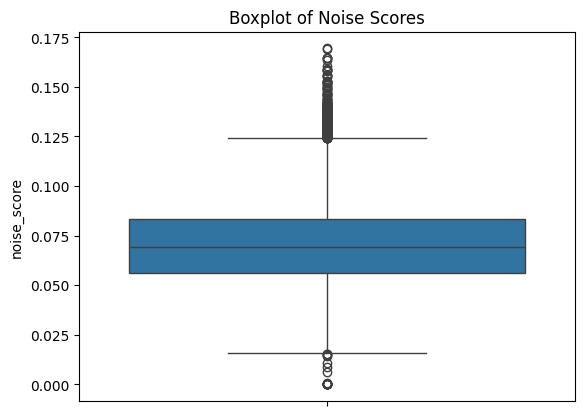

In [34]:
ax = sns.boxplot(data=df_meta["noise_score"])

plt.title('Boxplot of Noise Scores')
plt.show()

#### Interquartile Range

Picking images within our interquartile range, we can see visually that they are OK.

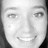

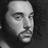

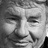

In [71]:
q1, median, q3 = np.quantile(df_meta["noise_score"], [0.25, 0.5,0.75])

q1_img_filepath = df_meta[df_meta["noise_score"] == q1]["file_path"].iloc[0]
q3_img_filepath = df_meta[df_meta["noise_score"] == q3]["file_path"].iloc[0]
median_img_filepath = df_meta[df_meta["noise_score"] == median]["file_path"].iloc[0]

load_print_images([q1_img_filepath,q3_img_filepath, median_img_filepath])

In [37]:
iqr = q3 - q1

lower_whisker = q1 - 1.5 * iqr
upper_whisker = q3 + 1.5 * iqr

In [82]:
q1, q3, lower_whisker, upper_whisker

(0.05620819561688122,
 0.0833723498974727,
 0.015461964195994,
 0.12411858131835993)

#### Outliers

The outliers have been calculated using a standard measure i.e. those images that have a lower or higher score than the lower or upper whisker i.e. images with a noise score < 0.015461964195994 or above 0.12411858131835993

**Low noise scores**

There are only 20 outliers with low noise scores: we see visually that they are all very dark and it is difficult to make out the image. This makes me think that there are likely images with slightly higher noise scores than this threshold that we should are also unusable. We already saw that an image at q1 i.e. with a noise score of 0.05620819561688122 was recognisably an image. We can do more analysis to find the best lower noise_score threshold.

**High noise scores**

There are far more outliers in this category (317) than in the low noise score category. We can see that there are more cartoons in this group, which is unsurprising since cartoons are often high contrast.

In [50]:
noise_outliers_higher = df_meta[df_meta["noise_score"] > upper_whisker].sort_values(by="noise_score", ascending=False)
noise_outliers_lower = df_meta[df_meta["noise_score"] < lower_whisker].sort_values(by="noise_score", ascending=True)

In [52]:
len(noise_outliers_higher), len(noise_outliers_lower)

(317, 20)

**Low Noise scores**

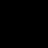

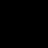

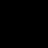

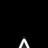

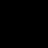

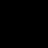

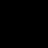

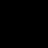

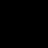

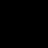

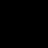

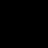

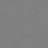

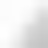

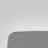

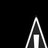

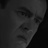

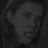

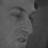

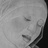

In [81]:
load_print_images(noise_outliers_lower["file_path"].iloc[:])

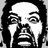

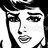

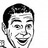

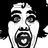

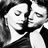

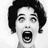

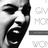

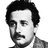

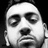

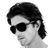

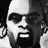

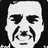

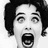

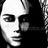

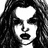

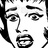

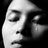

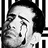

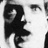

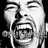

In [87]:
load_print_images(noise_outliers_higher["file_path"].iloc[:20])

## Duplicates

From randomly selecting images, I have noticed that there are duplicate images in this dataset.

I have used perceptual hashing using [imagehash](https://github.com/JohannesBuchner/imagehash) to identify duplicate images. Image hashes tell whether two images look nearly identical. It doesn't look at exact pixel values so is able to pick up near identical images. We can see that most of the duplicates found have the same noise score, which is a good sign that the hashing works as expected.

We have identified 2400 duplicates. Sometimes there is more than one copy of an image so rather than having 1200 images to drop, we would drop 1314 rows.

In [127]:
df_meta[df_meta.duplicated(subset='hash_value')].sort_values(by="hash_value")

,category,file_name,file_path,size_kb,dimensions,mode,mode_desc,image_format,is_jpg_extension,exif_details,noise_score,hash_value
24441,angry,Training_32571770.jpg,../data/FER-2013/train/angry/Training_32571770...,0.35,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.000000,0000000000000000
24735,angry,Training_96772745.jpg,../data/FER-2013/train/angry/Training_96772745...,0.35,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.000000,0000000000000000
24754,angry,Training_52563817.jpg,../data/FER-2013/train/angry/Training_52563817...,0.35,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.000000,0000000000000000
25168,angry,Training_10131352.jpg,../data/FER-2013/train/angry/Training_10131352...,0.35,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.000000,0000000000000000
27134,angry,Training_99531165.jpg,../data/FER-2013/train/angry/Training_99531165...,0.35,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.000000,0000000000000000
...,...,...,...,...,...,...,...,...,...,...,...,...
18468,surprise,Training_10227694.jpg,../data/FER-2013/train/surprise/Training_10227...,1.59,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.077121,ff7d2062e16948e2
18876,surprise,Training_27766183.jpg,../data/FER-2013/train/surprise/Training_27766...,1.55,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.058385,ff81ff82fa2e0022
14720,fear,Training_49198048.jpg,../data/FER-2013/train/fear/Training_49198048.jpg,1.87,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.097149,ff9fe0b0d2290a45
18983,surprise,Training_63470176.jpg,../data/FER-2013/train/surprise/Training_63470...,1.68,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.058649,ffa87692895c3582


In [121]:
duplicates = df_meta.groupby(['hash_value']).filter(lambda x: len(x) > 1)
duplicates_sorted_by_hash = duplicates.sort_values(by="hash_value")
duplicates_sorted_by_hash.tail()

,category,file_name,file_path,size_kb,dimensions,mode,mode_desc,image_format,is_jpg_extension,exif_details,noise_score,hash_value
14720,fear,Training_49198048.jpg,../data/FER-2013/train/fear/Training_49198048.jpg,1.87,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.097149,ff9fe0b0d2290a45
12841,fear,Training_27746315.jpg,../data/FER-2013/train/fear/Training_27746315.jpg,1.87,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.097149,ff9fe0b0d2290a45
14144,fear,Training_12587825.jpg,../data/FER-2013/train/fear/Training_12587825.jpg,1.68,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.058649,ffa87692895c3582
18983,surprise,Training_63470176.jpg,../data/FER-2013/train/surprise/Training_63470...,1.68,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.058649,ffa87692895c3582
14336,fear,Training_70012504.jpg,../data/FER-2013/train/fear/Training_70012504.jpg,1.68,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.058649,ffa87692895c3582


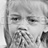

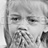

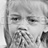

In [122]:
load_print_images(duplicates_sorted_by_hash.tail(3)["file_path"].values)

In [123]:
len(duplicates)

2400

In [124]:
duplicates_sorted_by_noise = duplicates.sort_values(by="noise_score", ascending=False)
duplicates_sorted_by_noise.head()

,category,file_name,file_path,size_kb,dimensions,mode,mode_desc,image_format,is_jpg_extension,exif_details,noise_score,hash_value
27418,angry,Training_80209767.jpg,../data/FER-2013/train/angry/Training_80209767...,2.17,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.149590,e747676228391b9a
25299,angry,Training_35899521.jpg,../data/FER-2013/train/angry/Training_35899521...,2.17,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.149590,e747676228391b9a
16543,surprise,Training_42143192.jpg,../data/FER-2013/train/surprise/Training_42143...,2.17,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.146148,9b84fed2867960d8
17473,surprise,Training_27672614.jpg,../data/FER-2013/train/surprise/Training_27672...,2.17,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.146148,9b84fed2867960d8
28204,angry,Training_28028740.jpg,../data/FER-2013/train/angry/Training_28028740...,1.79,48x48,L,"8-bit pixels, grayscale",JPEG,True,[],0.136115,c05e27f20f787c61


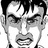

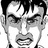

In [125]:
load_print_images(duplicates_sorted_by_noise.head(2)["file_path"].values)

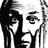

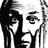

In [126]:
load_print_images(duplicates_sorted_by_noise.head()[2:4]["file_path"].values)